<a href="https://colab.research.google.com/github/sheamusfitz/DSPS_jFitzgerald/blob/master/EC/Complete_Analysis_Function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import sklearn as skl
from sklearn import cluster
from scipy.cluster.hierarchy import dendrogram, linkage

In [0]:
importlink = "https://raw.githubusercontent.com/sheamusfitz/DSPS_jFitzgerald/master/EC/Lo/Lotraj1_150410_2_Cine1_Np008251_Lo-02_precision_3p15nm.txt"

In [0]:
parameters = {
    "min_d_const": 1,
    "max_d_const": 3
}

In [0]:
def calICVar(X, labels):
    """calculates the intracluster variance
    input 
    X:  an NxM-dimensional feature vecture for N observcations and M features
    labels: an N dimensional vector of labels
    """
    icvar = 0
    # print(np.unique(labels))
    for n in np.unique(labels):
        #print (n, X[labels == n].std() ** 2)
        icvar += np.sum((X[labels == n] - X[labels == n].mean())**2)
        #X[labels == n].var() 
    # print(n, icvar)
    print("intra cluster variance for {} clusters: {:f}".format(n+1, icvar))
    return icvar

In [0]:
def clusterer(importlink, parameters):
    positions_list = np.genfromtxt(importlink)

    min_d_const = parameters["min_d_const"]
    max_d_const = parameters["max_d_const"]

    last_index = int(len(positions_list)*0.8)
    # print(last_index)

    indexbuffer = 50

    size_ = 'xx-large'
    plt.figure(figsize = (10,10))
    plt.plot(positions_list[indexbuffer:last_index+indexbuffer,0],
             positions_list[indexbuffer:last_index+indexbuffer,1], 'k', lw=1)
    plt.title("Single Particle Tracking Path", fontsize=size_)
    plt.xlabel("x-position (μm)", fontsize=size_)
    plt.ylabel("y-position (μm)", fontsize=size_)
    plt.show()

    diffusions = pd.DataFrame()

    for i in range(min_d_const, max_d_const+1):
        ii = 2**(i-1) #i
        # print(i)

        diffusions['D+'+str(ii)] = [sum((positions_list[j+indexbuffer]
                                         -positions_list[j+indexbuffer+ii])**2)\
                                    /(4 * ii) for j in range(last_index)]
        diffusions['D-'+str(ii)] = [sum((positions_list[j+indexbuffer]
                                         -positions_list[j+indexbuffer-ii])**2)\
                                    /(4 * ii) for j in range(last_index)]

    for i in range(min_d_const, max_d_const+1):
        ii = 2**(i-1) #i
        plt.figure(figsize=(13,5))
        plt.hist(diffusions["D-"+str(ii)], bins=1000)
        # plt.ylim(-10**-7, 10**-6)
        # plt.yscale('log')
        plt.title("D-"+str(ii))
        # plt.xlim(-2, 10)
        plt.show()

    np.random.seed(122409)
    tv = []

    for i in range(1, 10):
        km = skl.cluster.k_means(diffusions.to_numpy(), i)
        tv.append(calICVar(diffusions.to_numpy(), km[1]))
        
    plt.plot(range(1,10), tv)
    # plt.ylim(0)
    plt.xlabel("number of clusters")
    plt.ylabel("intracluster variance")
    plt.show()

    #######

    diff_kmclust = skl.cluster.KMeans(n_clusters = 2,
                                      random_state=222317).fit(diffusions)

    plt.figure(figsize=(20,10))
    plt.subplot(121)
    plt.title("Single Particle Tracking Path, Clustered", fontsize=size_)
    plt.xlabel("x-position (μm)", fontsize=size_)
    plt.ylabel("y-position (μm)", fontsize=size_)
    plt.scatter(positions_list[indexbuffer:last_index+indexbuffer,0],
                positions_list[indexbuffer:last_index+indexbuffer,1],
                c=diff_kmclust.labels_,
                alpha=1, s=2, cmap="bwr",vmin=0)
    plt.subplot(122)
    plt.scatter(positions_list[indexbuffer:last_index+indexbuffer,0],
                positions_list[indexbuffer:last_index+indexbuffer,1],
                c=diff_kmclust.labels_,
                alpha=1, s=2, cmap="bwr_r")
    plt.show()

    ########

    size_ = 15
    alpha_ = 0.7
    pl_len = 150
    pl_start = 0
    bigger = 0.15

    for pl_start in np.arange(500, last_index-500, 500):
        print(pl_start)
        plt.figure(figsize=(12,5))
        plt.subplot(121)

        plt.scatter(positions_list[pl_start+indexbuffer:pl_start+pl_len+indexbuffer,0],
                    positions_list[pl_start+indexbuffer:pl_start+pl_len+indexbuffer,1],
                    c=diff_kmclust.labels_[pl_start:pl_start+pl_len],
                    s=size_, alpha=alpha_, cmap='bwr')
        plt.colorbar()
        plt.title("Tracking Path by Cluster", fontsize=size_)
        plt.xlabel("x-position (μm)", fontsize=size_)
        plt.ylabel("y-position (μm)", fontsize=size_)
        plt.plot(positions_list[pl_start+indexbuffer:pl_start+pl_len+indexbuffer,0],
                positions_list[pl_start+indexbuffer:pl_start+pl_len+indexbuffer,1],
                lw=1, alpha=0.4)
        
        
        plt.xlim(plt.xlim()[0],plt.xlim()[0]+bigger)
        plt.ylim(plt.ylim()[0],plt.ylim()[0]+bigger)
        
        plt.subplot(122)
        plt.plot(np.arange(pl_start, pl_start+pl_len),
                 diff_kmclust.labels_[pl_start:pl_start+pl_len], 'k', lw=1)
        plt.scatter(np.arange(pl_start, pl_start+pl_len),
                    diff_kmclust.labels_[pl_start:pl_start+pl_len],
                    c=diff_kmclust.labels_[pl_start:pl_start+pl_len],
                    cmap = 'bwr', s=size_)
        plt.xlabel("Timestep Index")
        plt.ylabel("Cluster Number")
        plt.ylim(-1,2)
        plt.show()


    xmax=0.0002

    plotter0 = np.where(diff_kmclust.labels_==0, diffusions["D+1"], np.nan)
    plotter0 = plotter0[~np.isnan(plotter0)]
    plt.hist(plotter0, bins=1000, color="b")
    plt.xlim(0,xmax)
    plt.title("$D_{+1}$, Cluster 0")
    plt.ylabel("Counts")
    plt.xlabel("$D_{+1}$")
    plt.show()

    plotter1 = np.where(diff_kmclust.labels_==1, diffusions["D+1"], np.nan)
    plotter1 = plotter1[~np.isnan(plotter1)]
    plt.hist(plotter1, bins=1000, color="r")
    plt.xlim(0,xmax)
    plt.title("$D_{+1}$, Cluster 1")
    plt.ylabel("Counts")
    plt.xlabel("$D_{+1}$")
    plt.show()

    plt.hist(plotter0, bins=500, alpha=0.7, color='b')
    plt.hist(plotter1, bins=500, alpha=0.7, color='r')
    plt.xlim(0,xmax)
    plt.title("$D_{+1}$, Both Clusters")
    plt.ylabel("Counts")
    plt.xlabel("$D_{+1}$")
    plt.show()

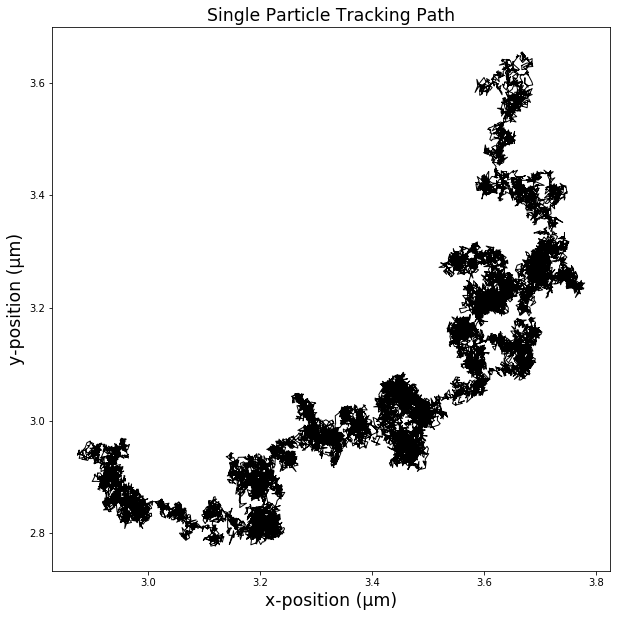

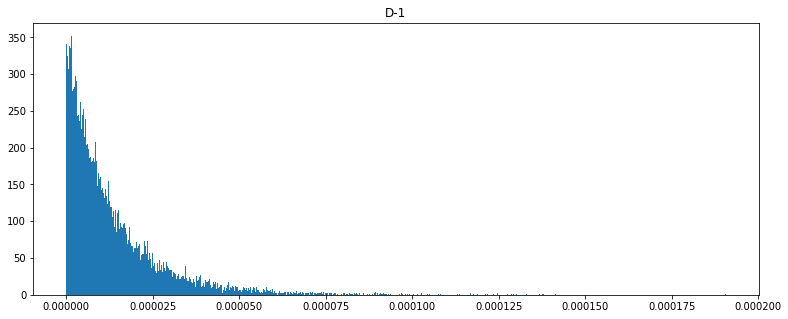

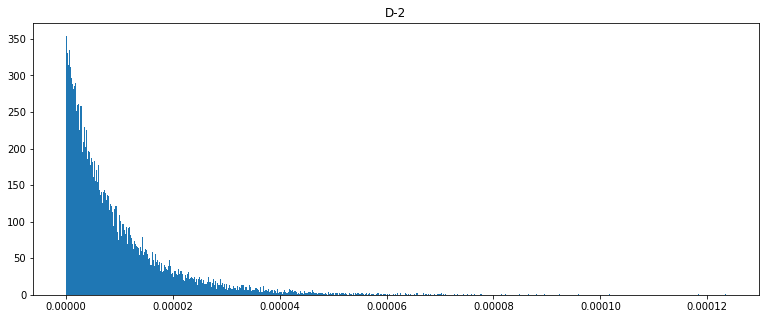

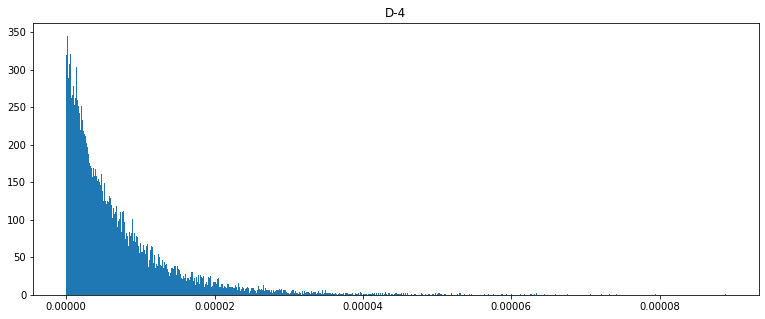

intra cluster variance for 1 clusters: 0.000018
intra cluster variance for 2 clusters: 0.000015
intra cluster variance for 3 clusters: 0.000015
intra cluster variance for 4 clusters: 0.000015
intra cluster variance for 5 clusters: 0.000015
intra cluster variance for 6 clusters: 0.000015
intra cluster variance for 7 clusters: 0.000015
intra cluster variance for 8 clusters: 0.000014
intra cluster variance for 9 clusters: 0.000014


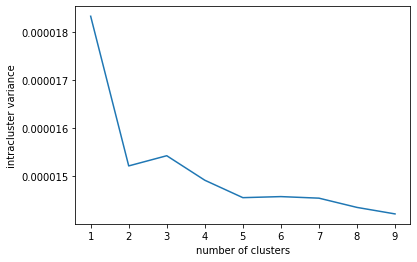

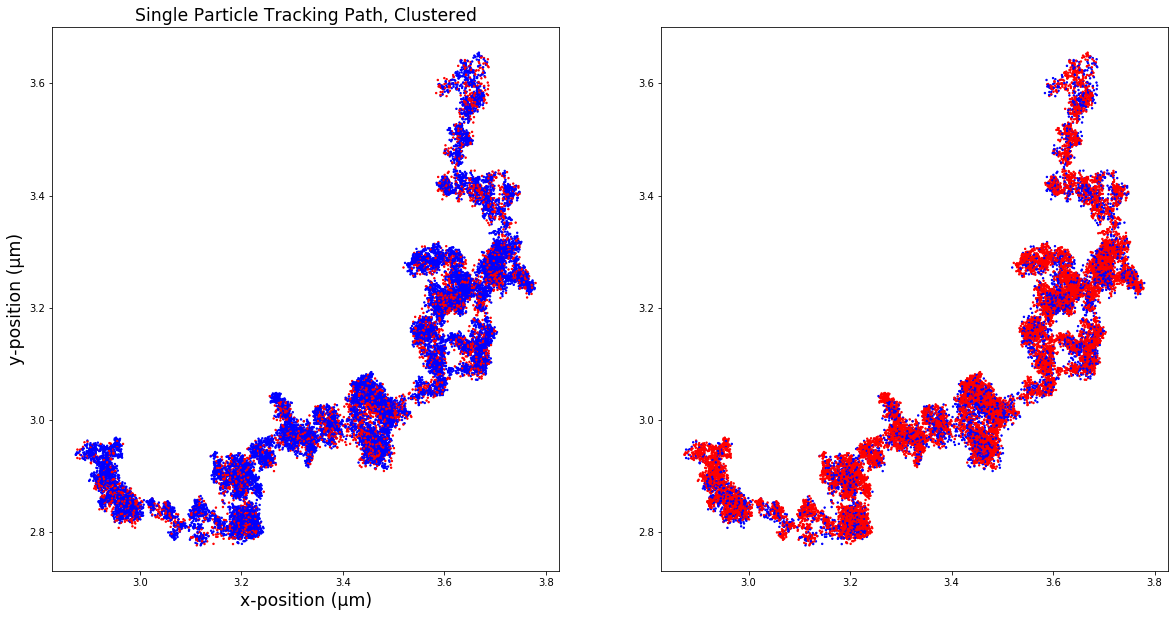

500


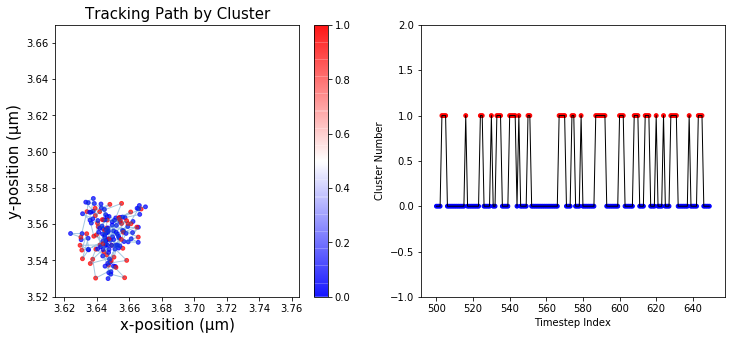

1000


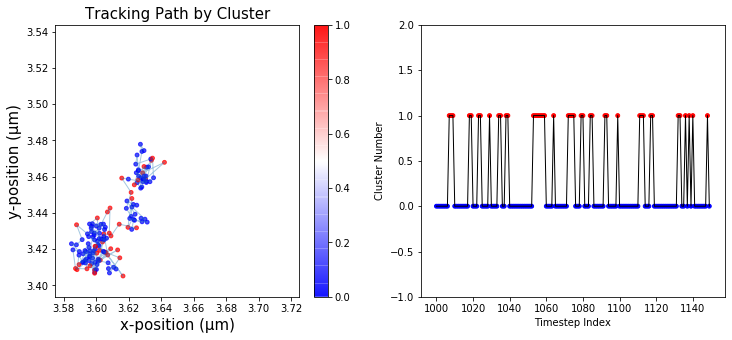

1500


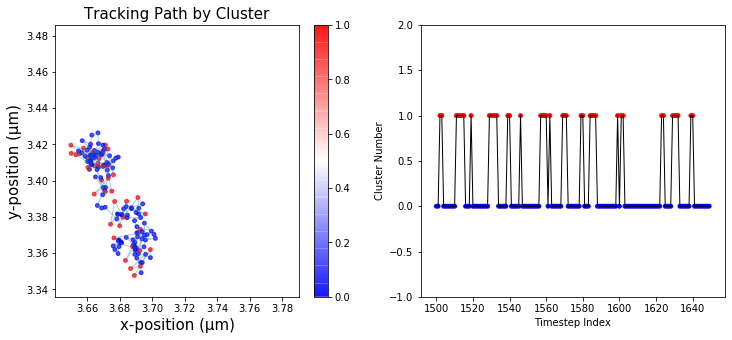

2000


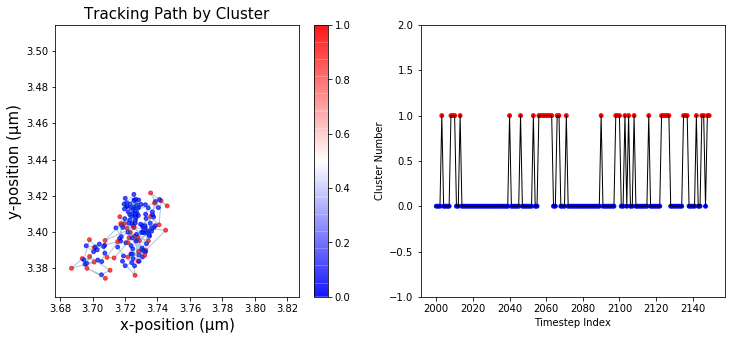

2500


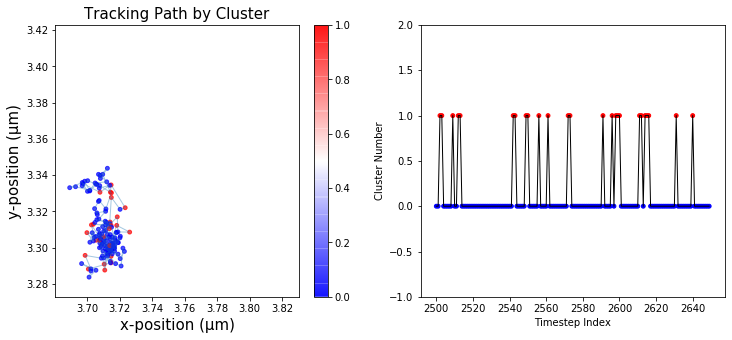

3000


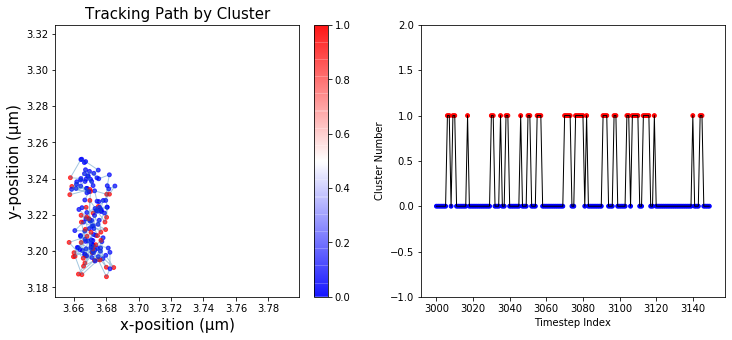

3500


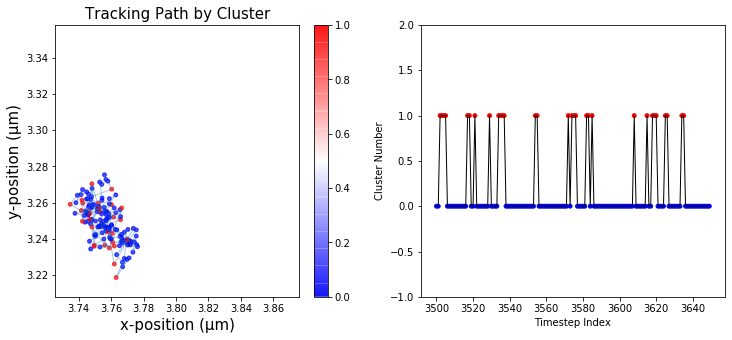

4000


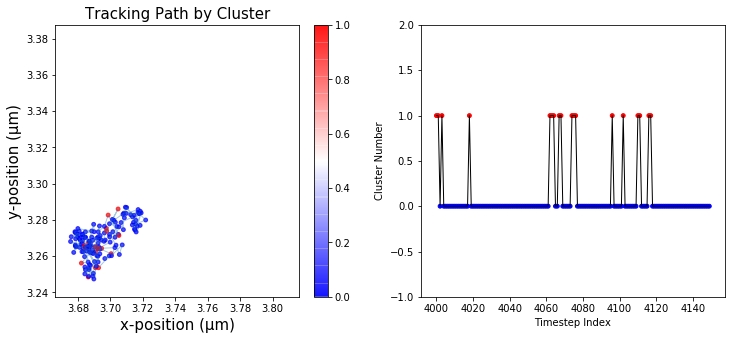

4500


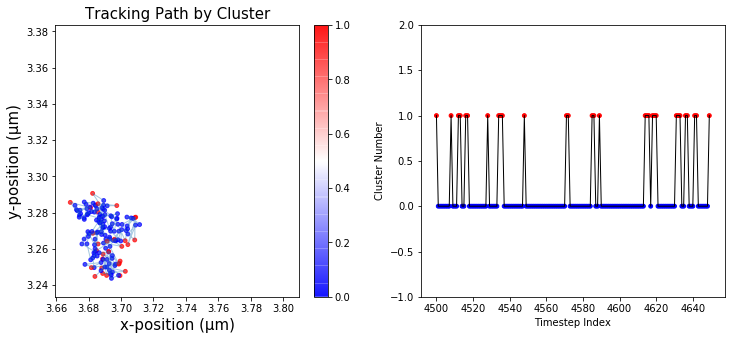

5000


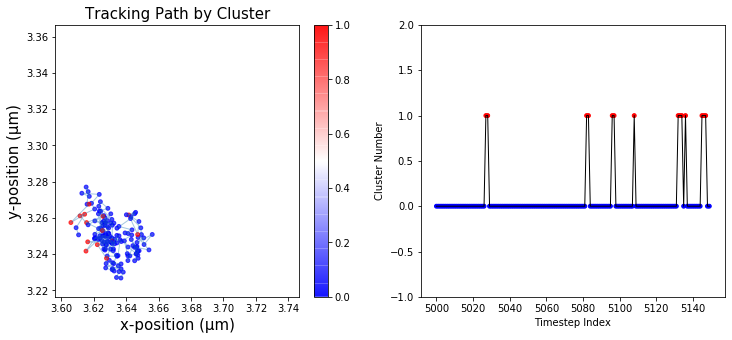

5500


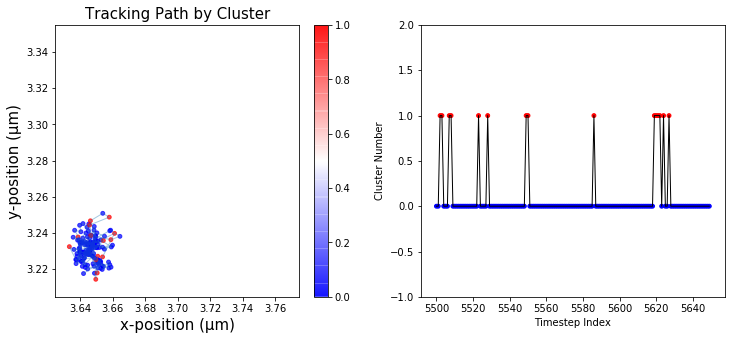

6000


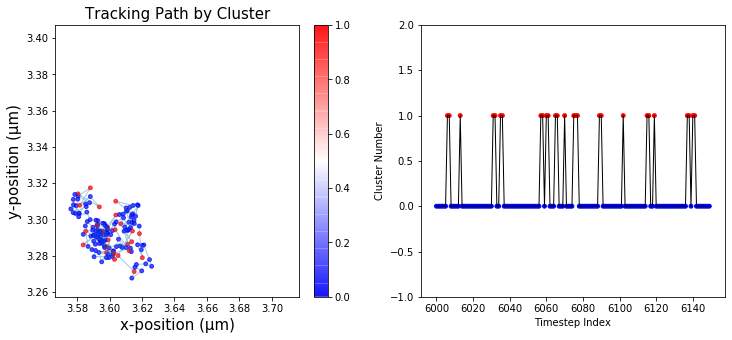

6500


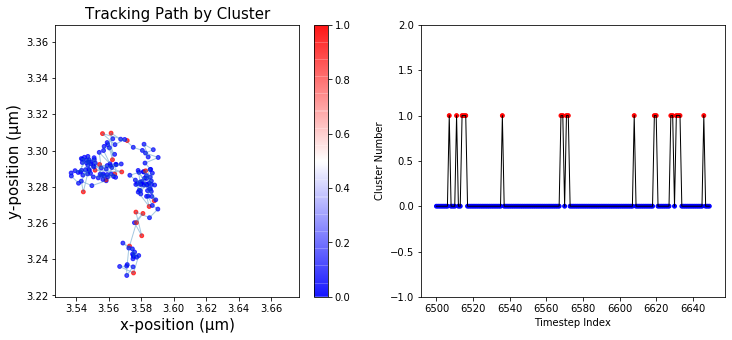

7000


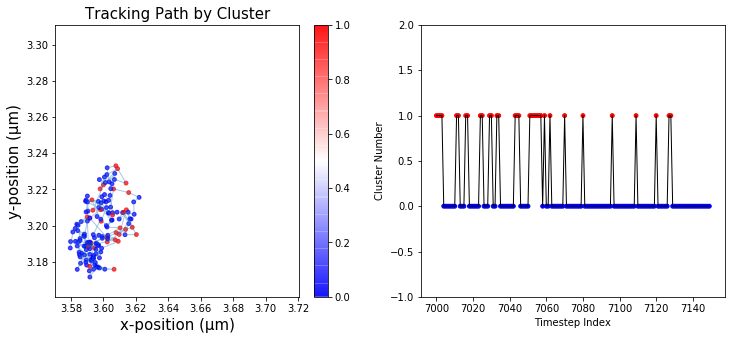

7500


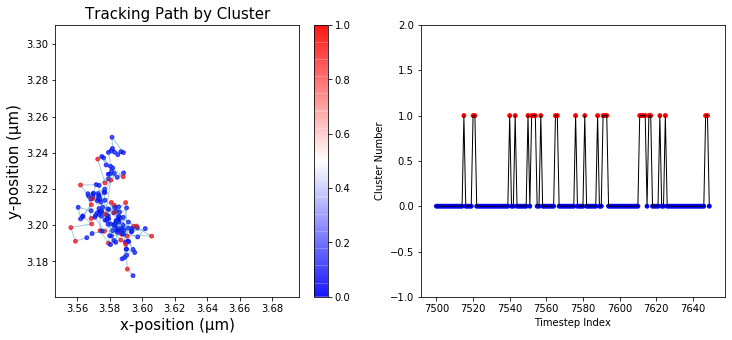

8000


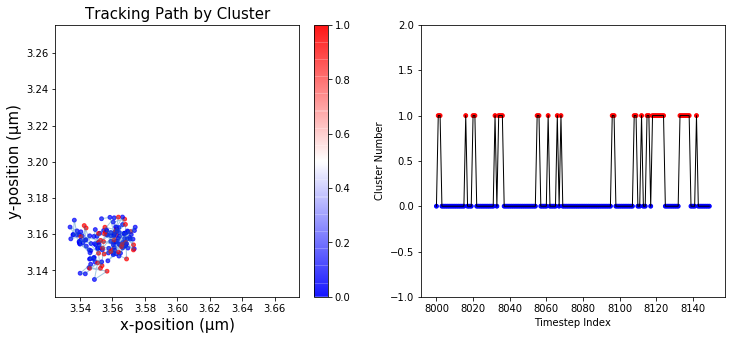

8500


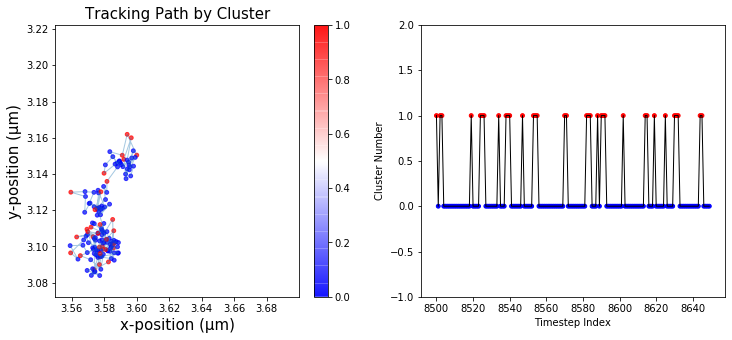

9000


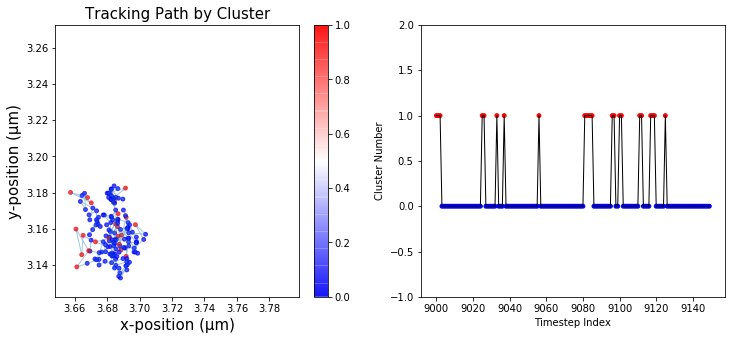

9500


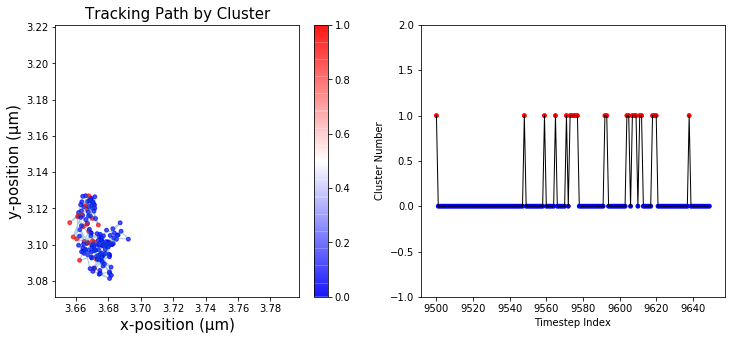

10000


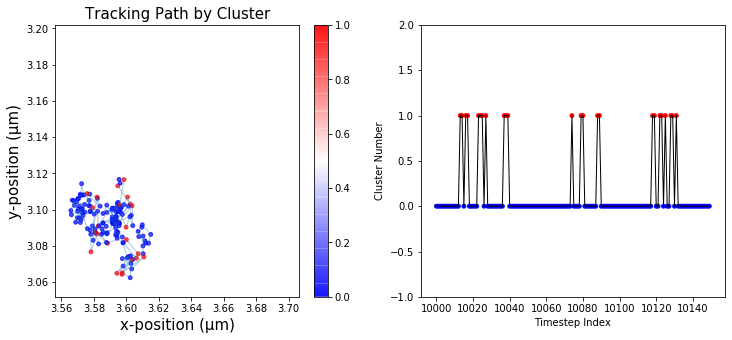

10500


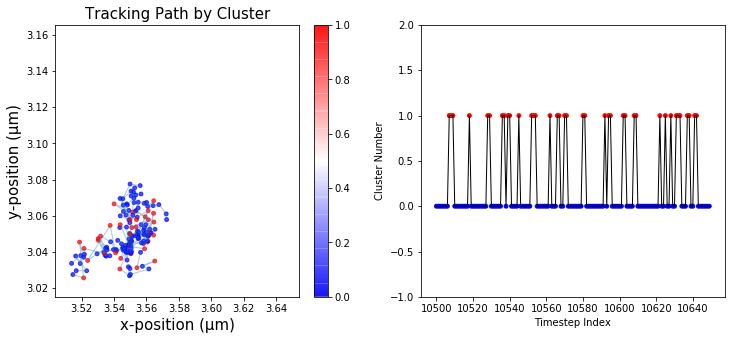

11000


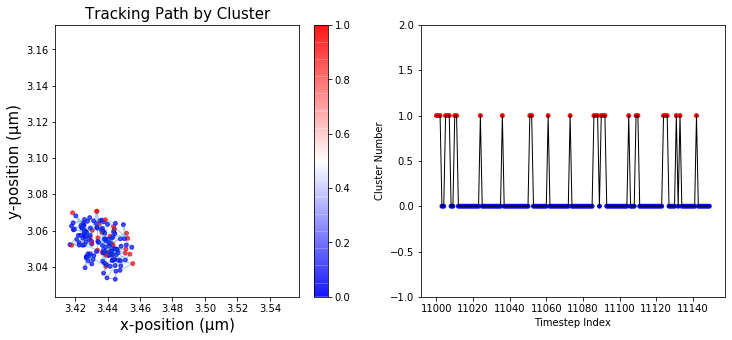

11500


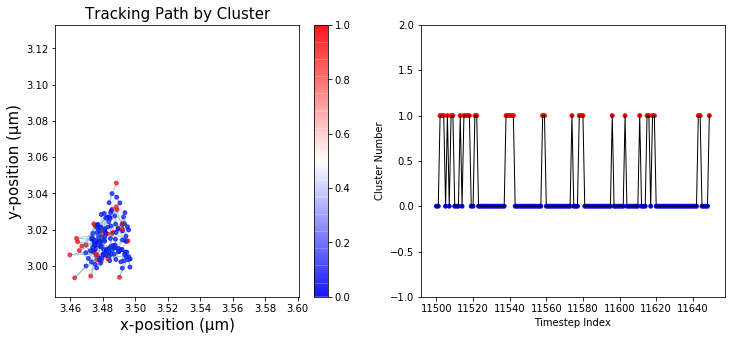

12000


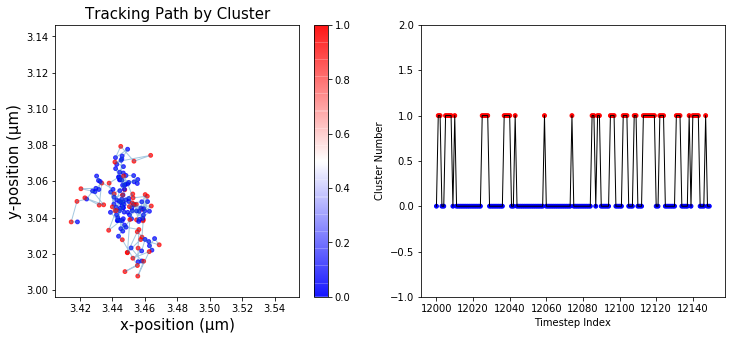

12500


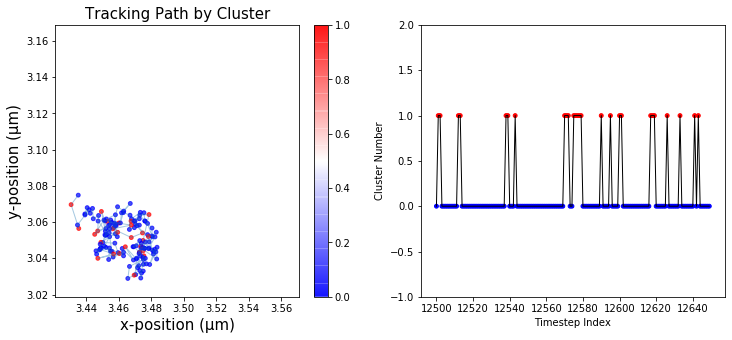

13000


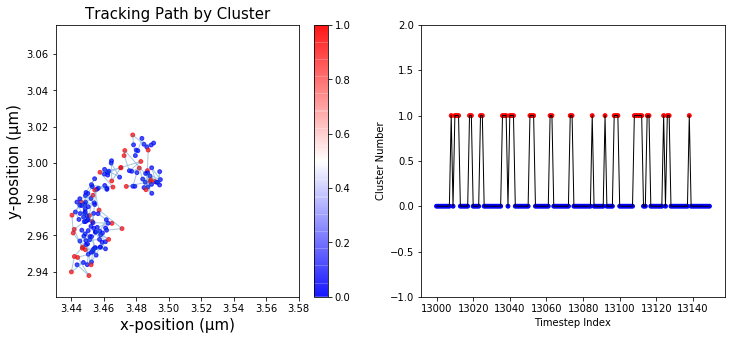

13500


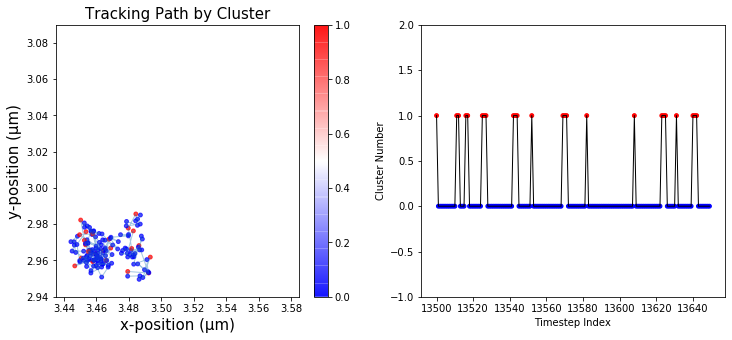

14000


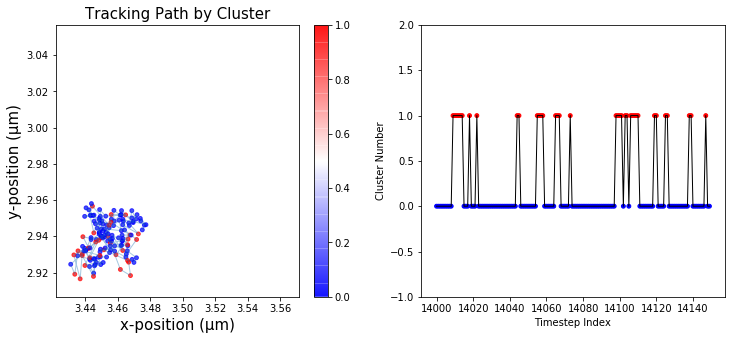

14500


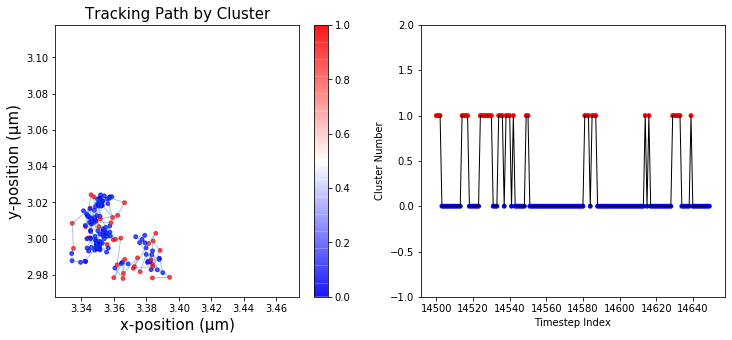

15000


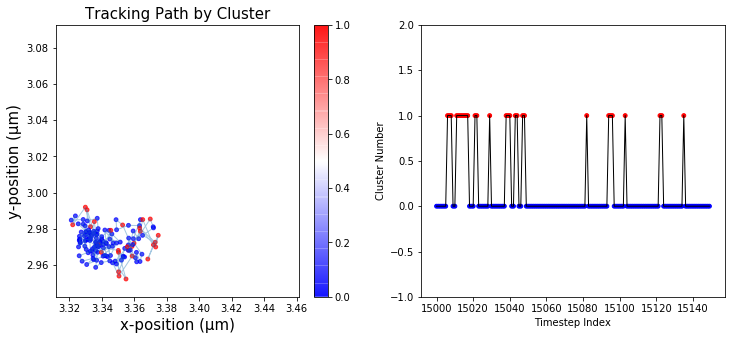

15500


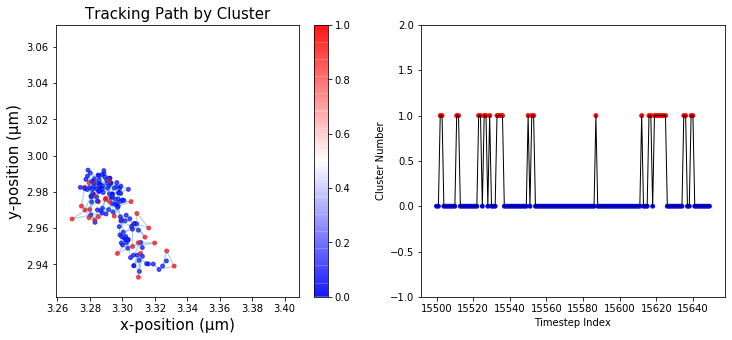

16000


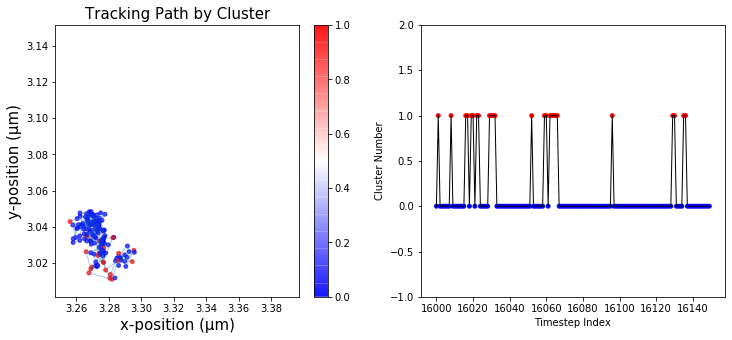

16500


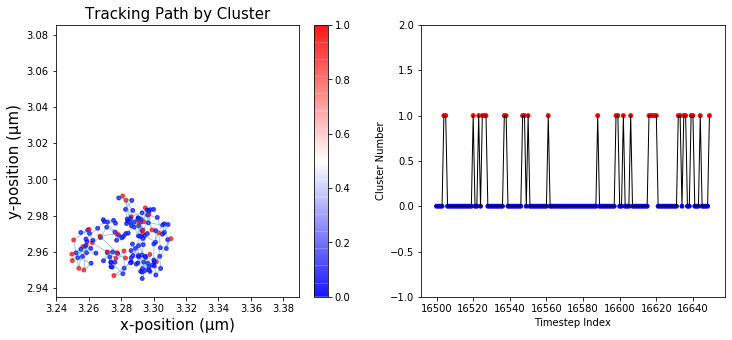

17000


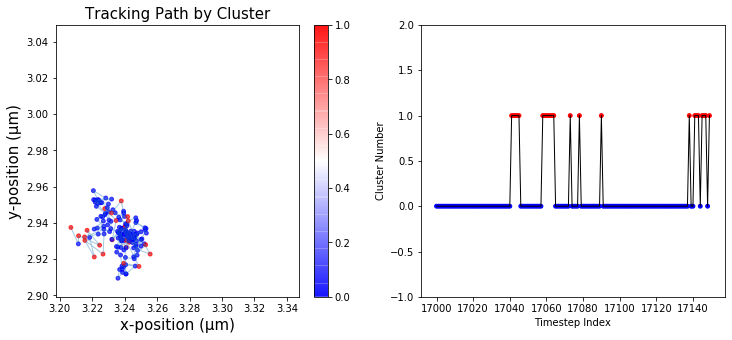

17500


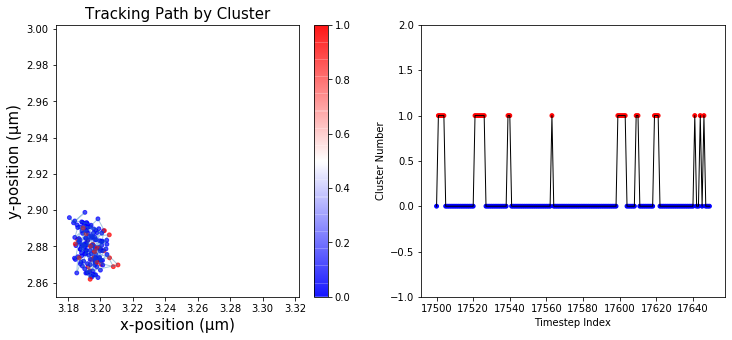

18000


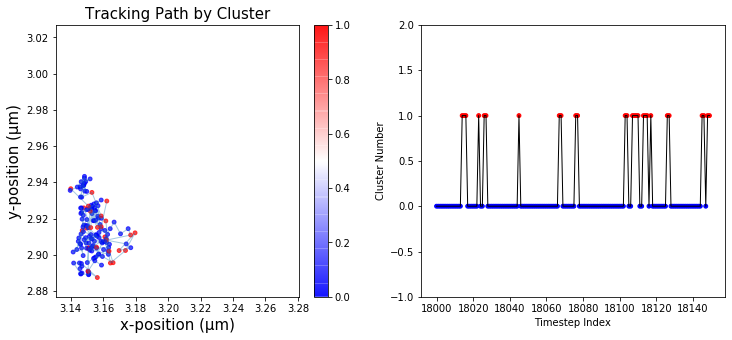

18500


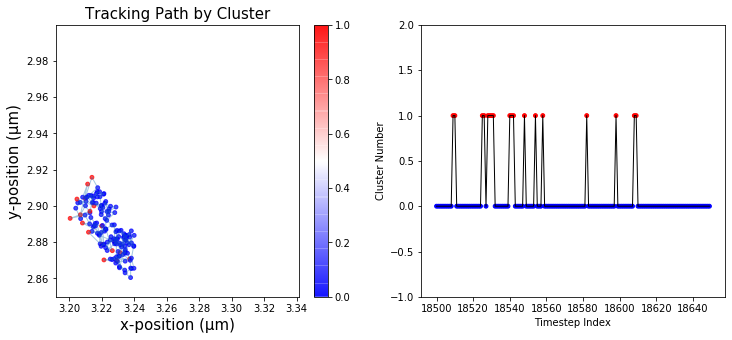

19000


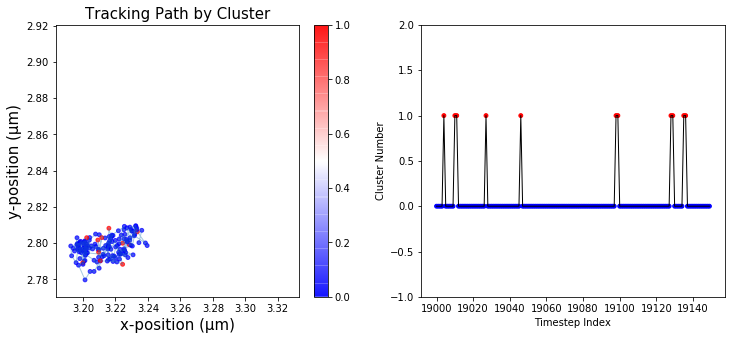

19500


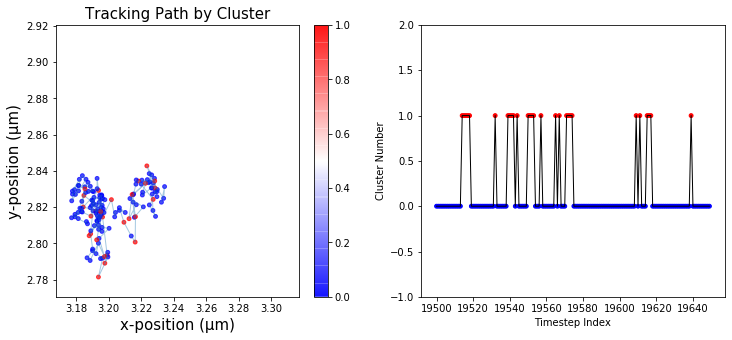

20000


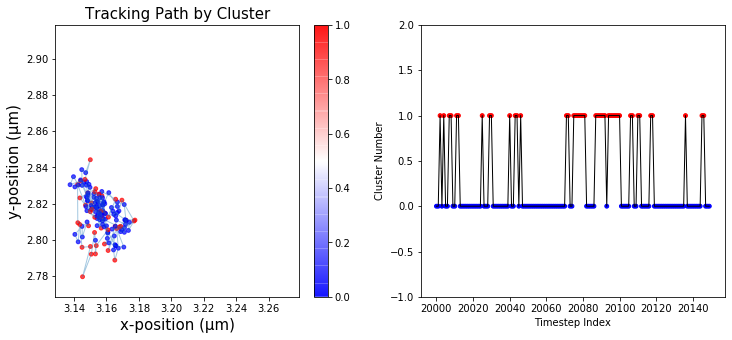

20500


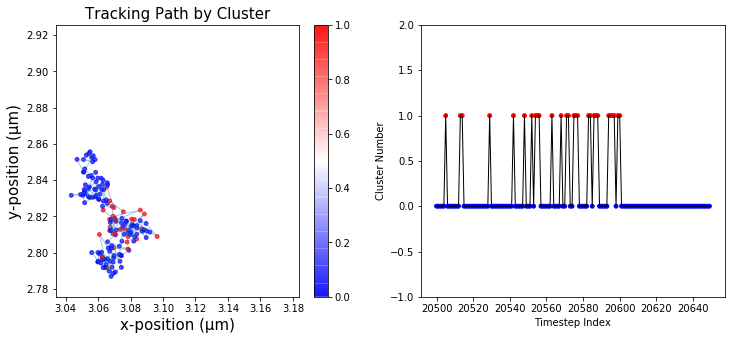

21000


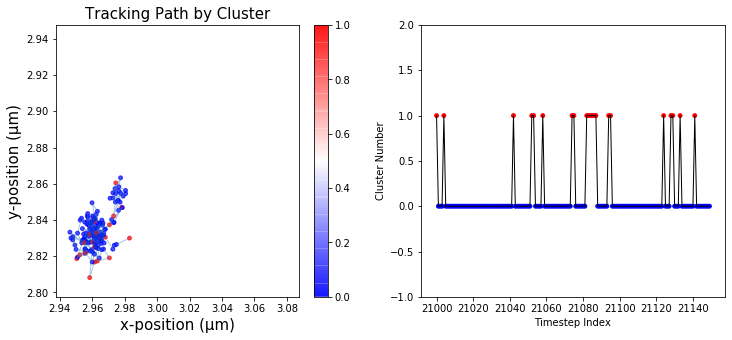

21500


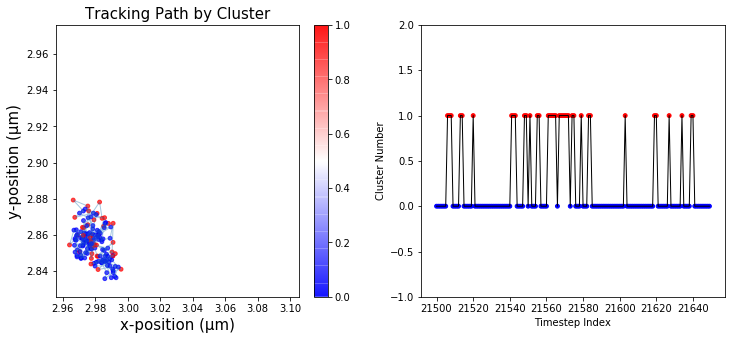

22000


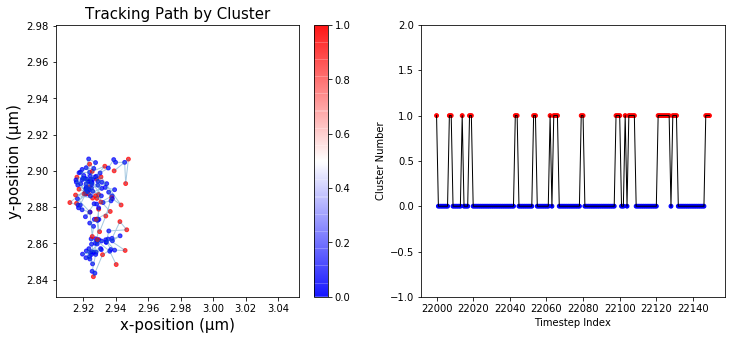

22500


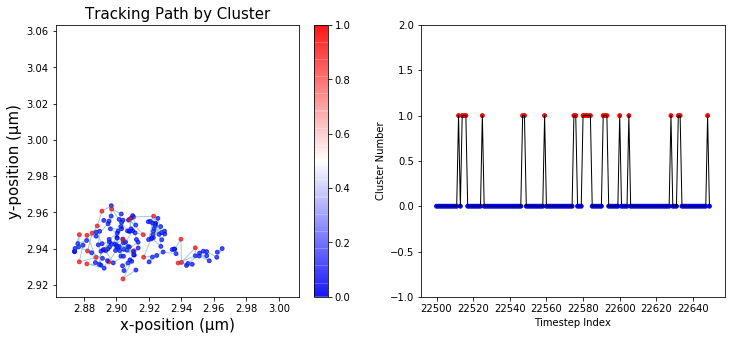

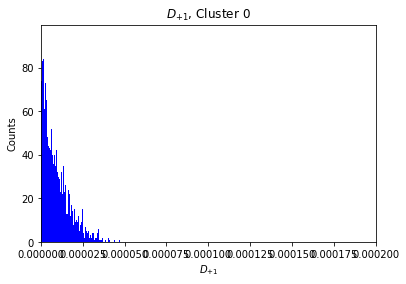

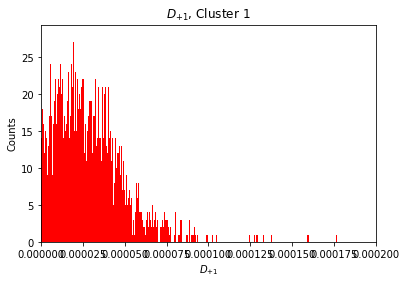

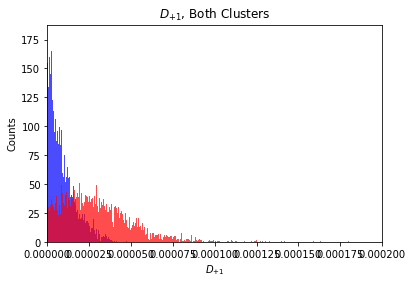

In [57]:
LO_1 = "https://raw.githubusercontent.com/sheamusfitz/DSPS_jFitzgerald/master/EC/Lo/Lotraj1_150410_2_Cine1_Np008251_Lo-02_precision_3p15nm.txt"
LO_10 = "https://raw.githubusercontent.com/sheamusfitz/DSPS_jFitzgerald/master/EC/Lo/Lotraj10_150409_3_Cine1_Np000002_Lo-03_precision_2p5nm.txt"
LO_7 = "https://raw.githubusercontent.com/sheamusfitz/DSPS_jFitzgerald/master/EC/Lo/Lotraj7_150325_1_Cine6_Np118252_Lo-01_precision_3p02nm.txt"

LD_1 = "https://raw.githubusercontent.com/sheamusfitz/DSPS_jFitzgerald/master/EC/Ld/Ldtraj1_150410_2_Cine4_Np004495_Ld_precision_3p61nm.txt"
LD_7 = "https://raw.githubusercontent.com/sheamusfitz/DSPS_jFitzgerald/master/EC/Ld/Ldtraj7_150409_3_Cine3_Np008959_Ld-01_precision_4p22nm.txt"

clusterer(LO_7, parameters)

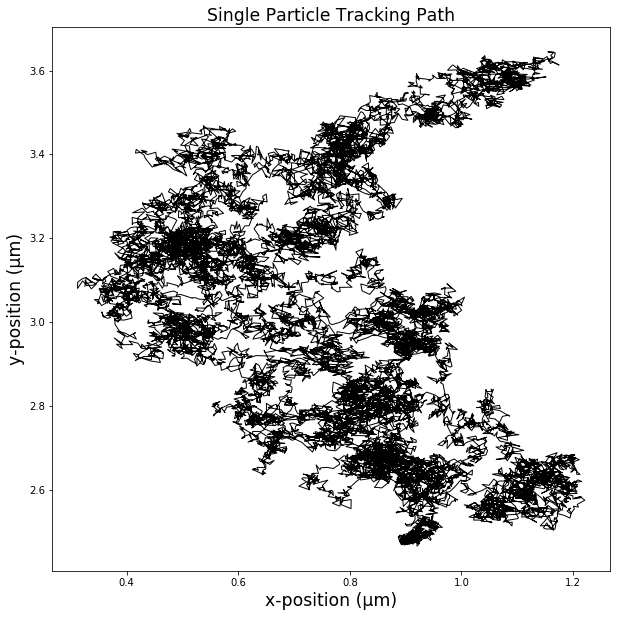

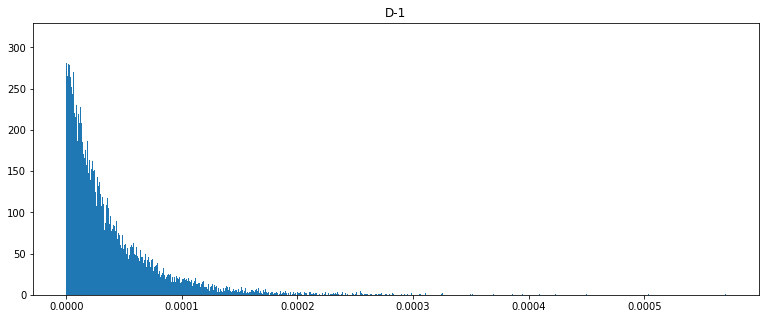

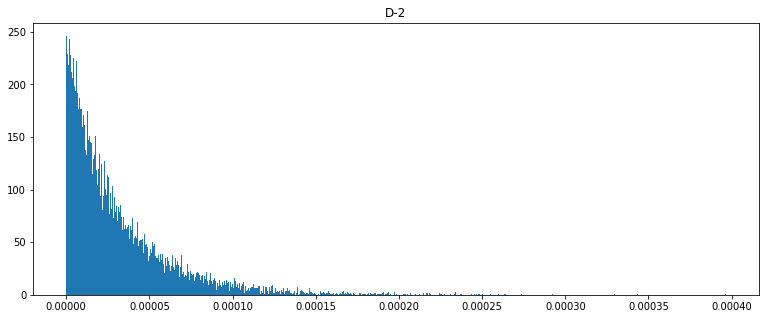

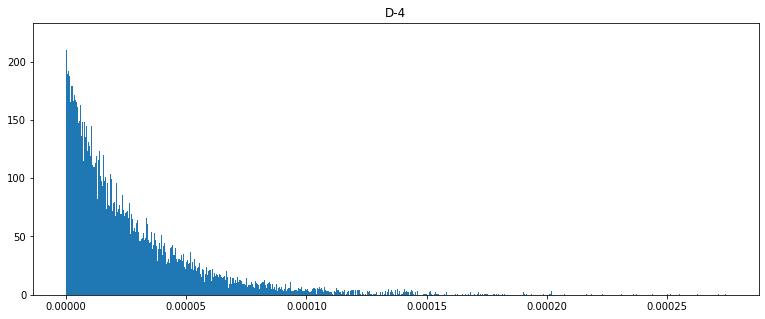

intra cluster variance for 1 clusters: 0.000133
intra cluster variance for 2 clusters: 0.000108
intra cluster variance for 3 clusters: 0.000110
intra cluster variance for 4 clusters: 0.000106
intra cluster variance for 5 clusters: 0.000105
intra cluster variance for 6 clusters: 0.000105
intra cluster variance for 7 clusters: 0.000103
intra cluster variance for 8 clusters: 0.000103
intra cluster variance for 9 clusters: 0.000102


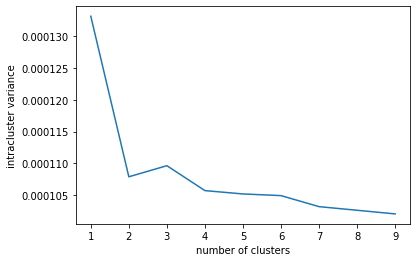

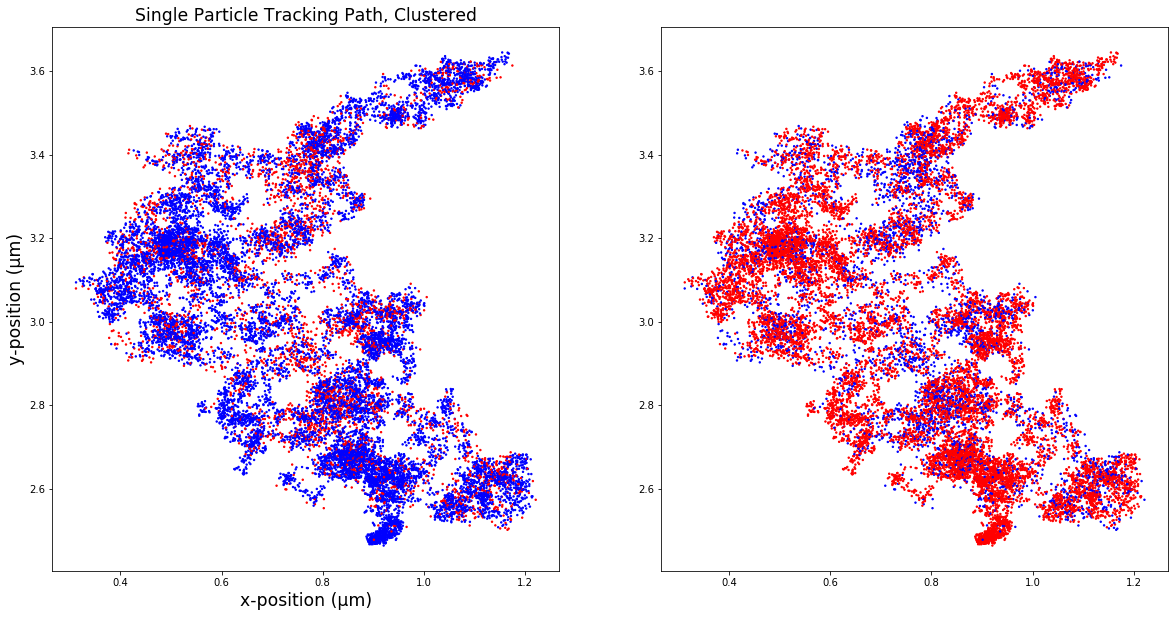

500


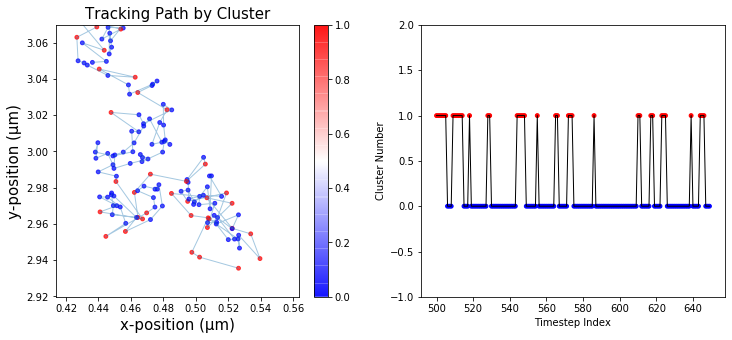

1000


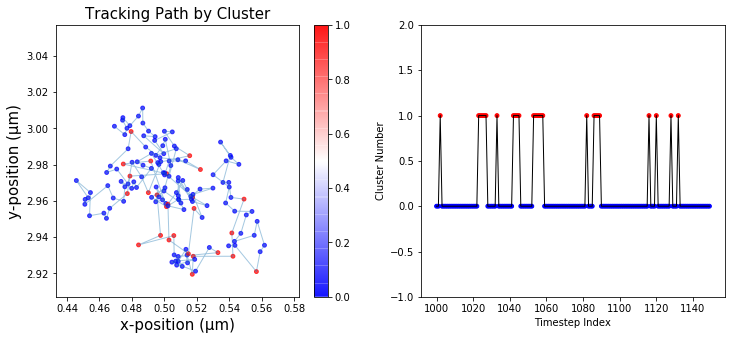

1500


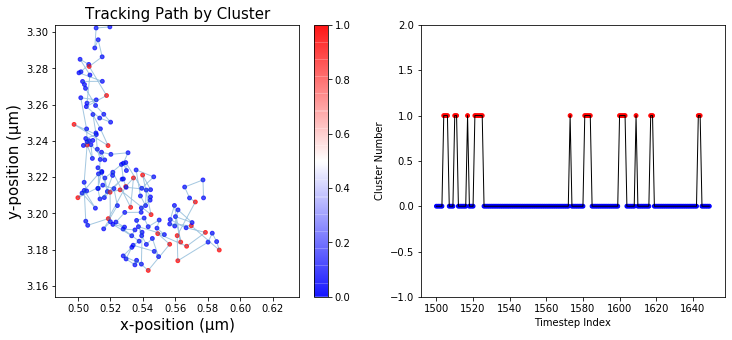

2000


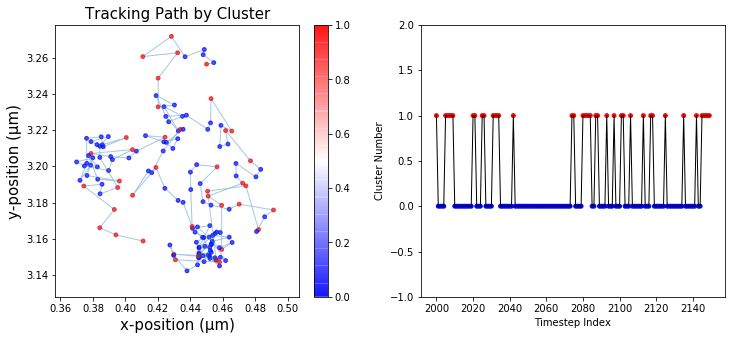

2500


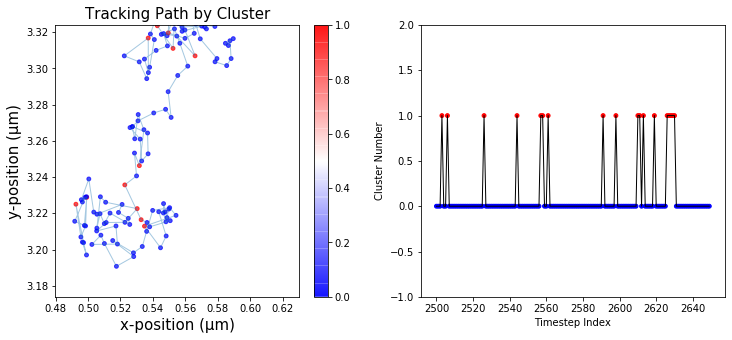

3000


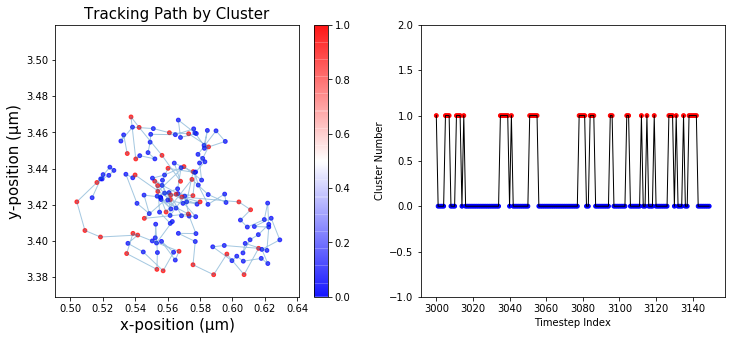

3500


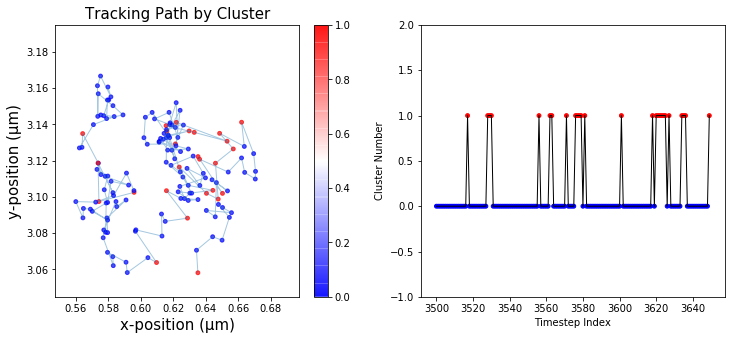

4000


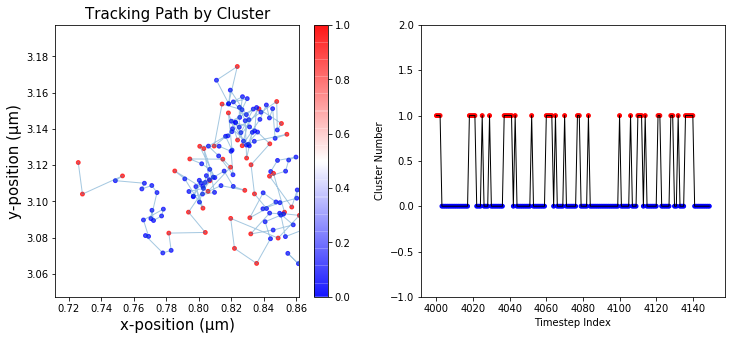

4500


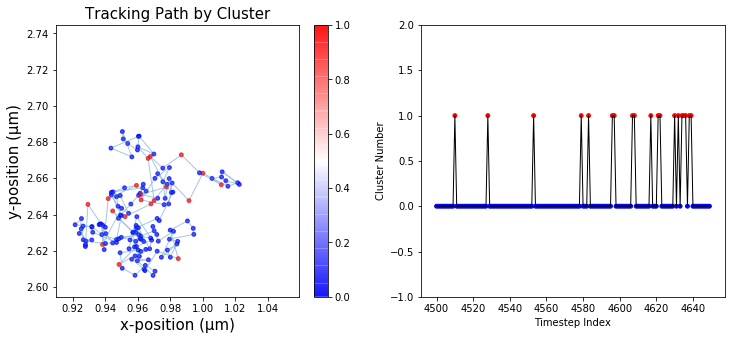

5000


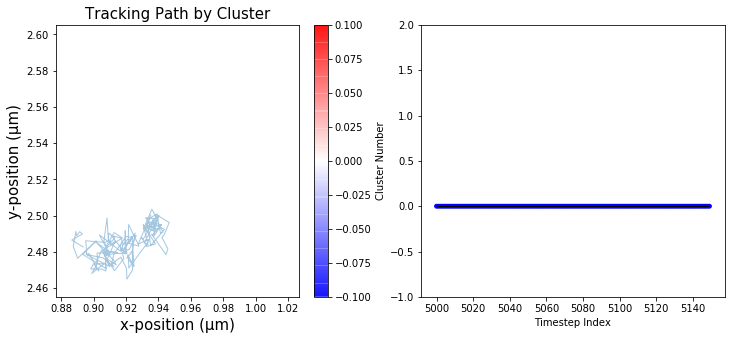

5500


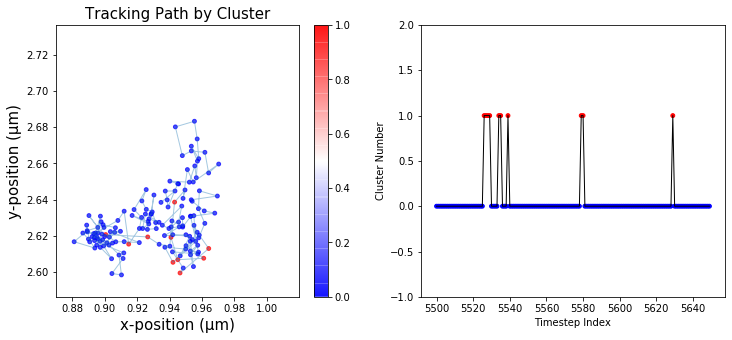

6000


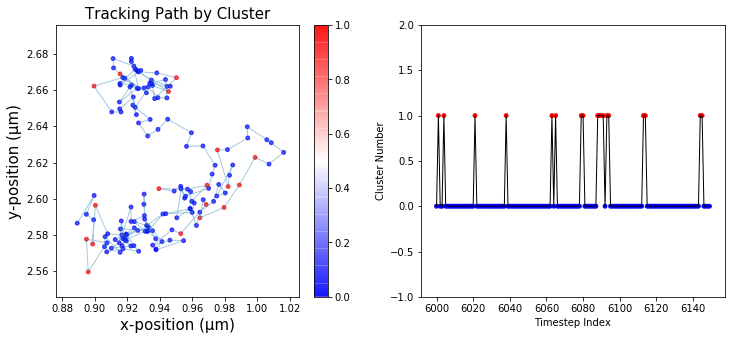

6500


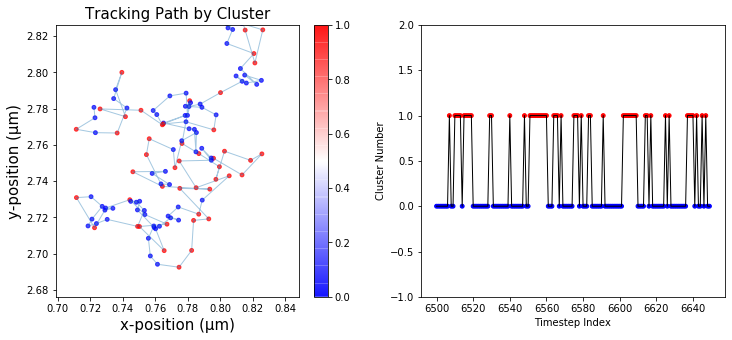

7000


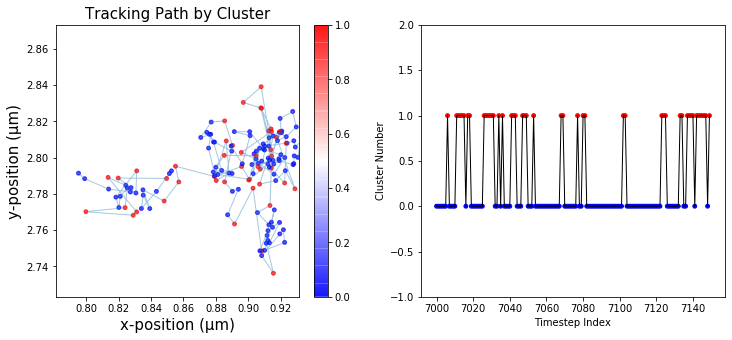

7500


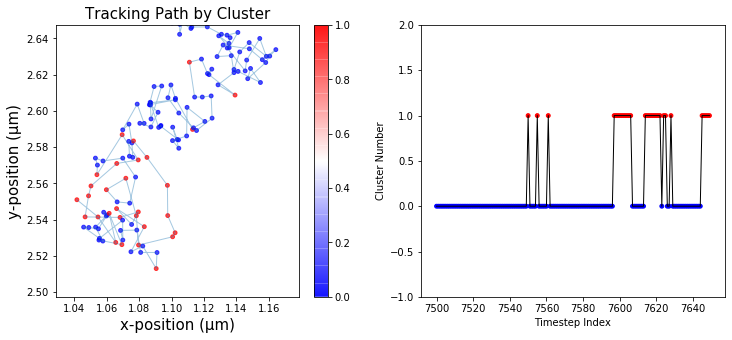

8000


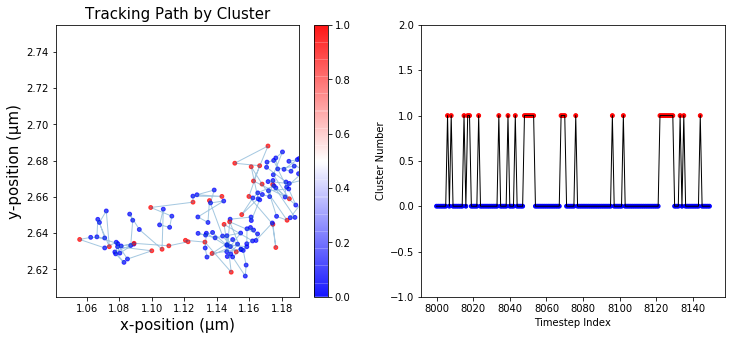

8500


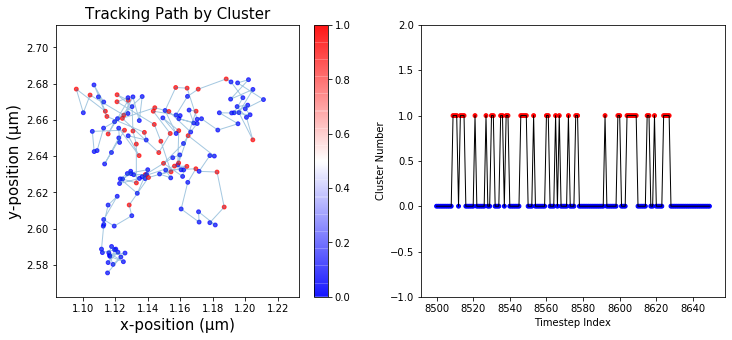

9000


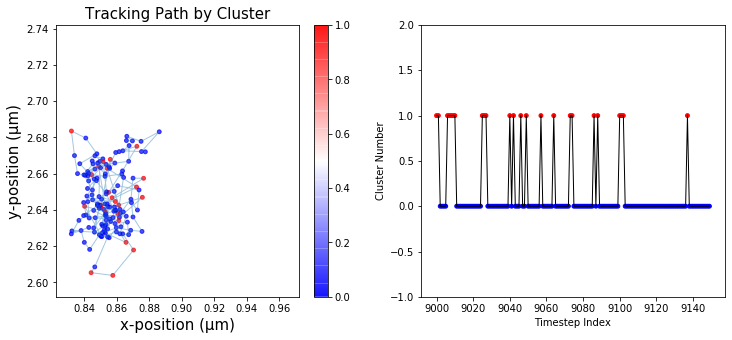

9500


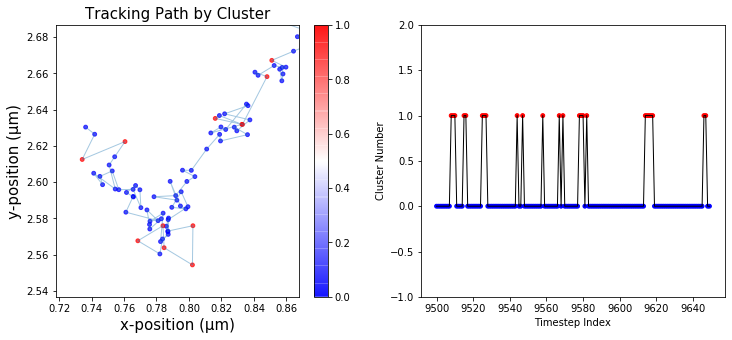

10000


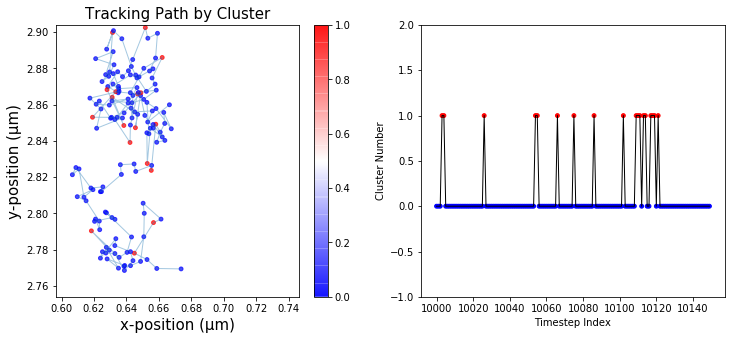

10500


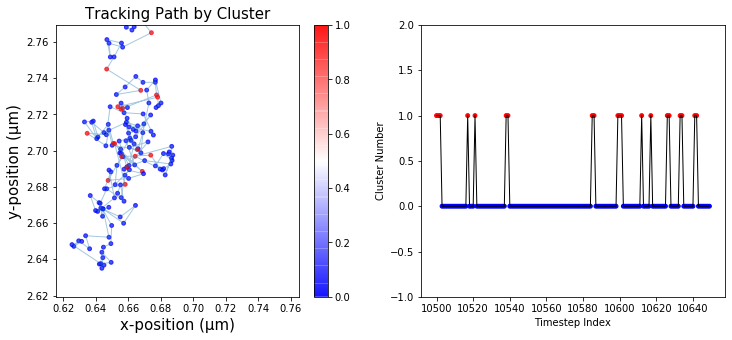

11000


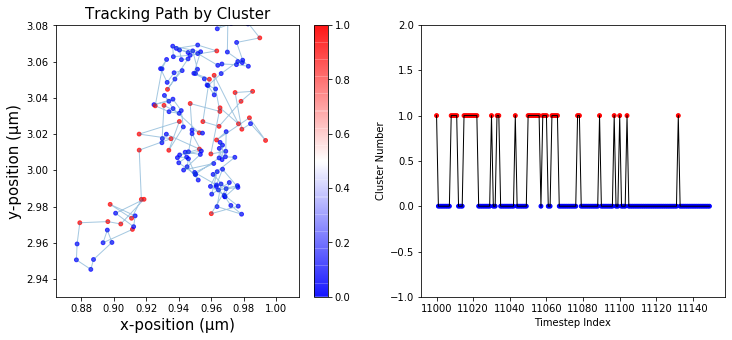

11500


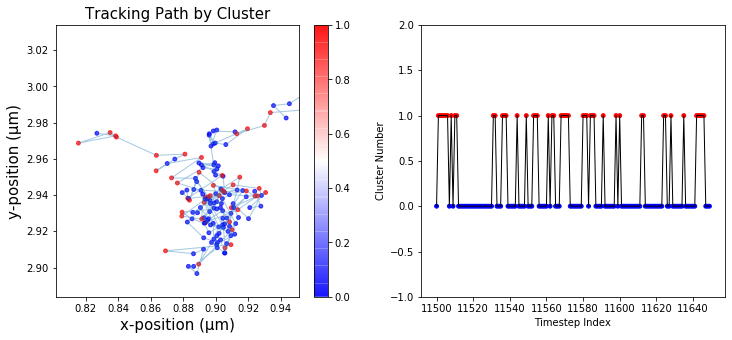

12000


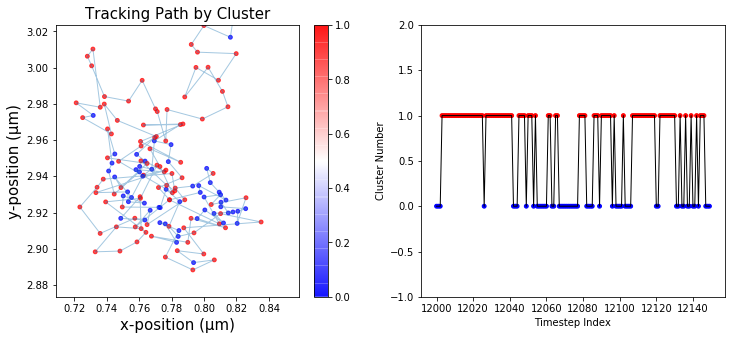

12500


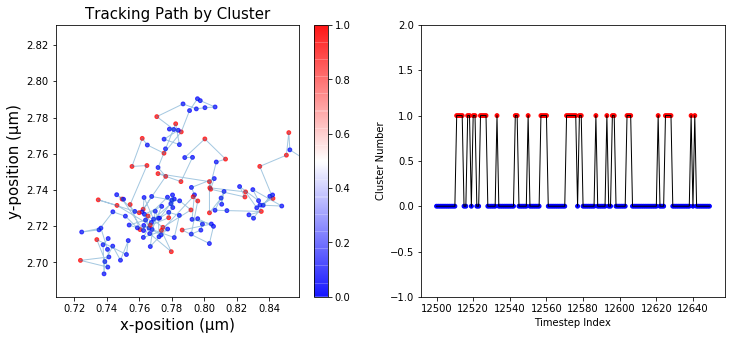

13000


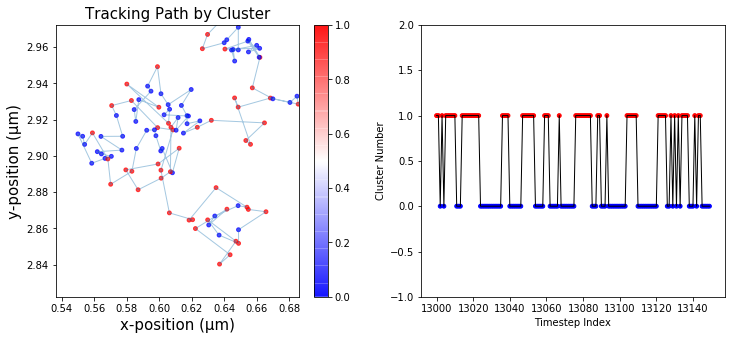

13500


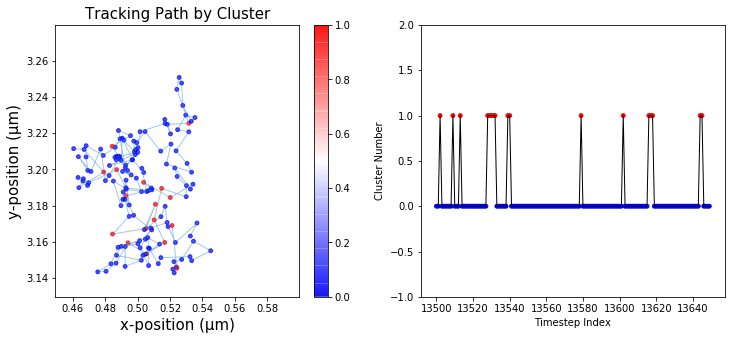

14000


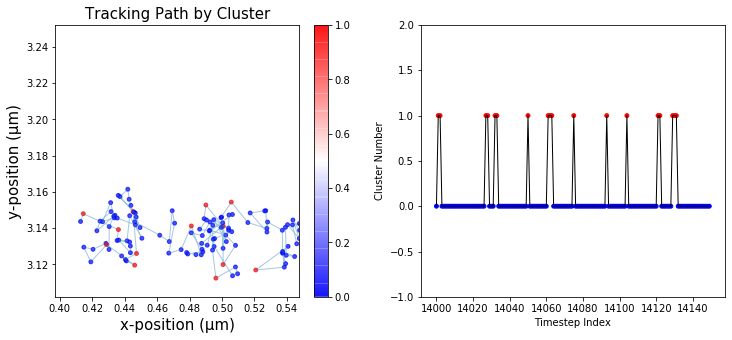

14500


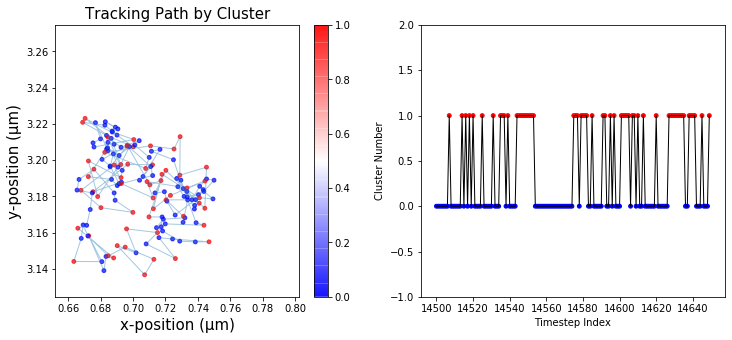

15000


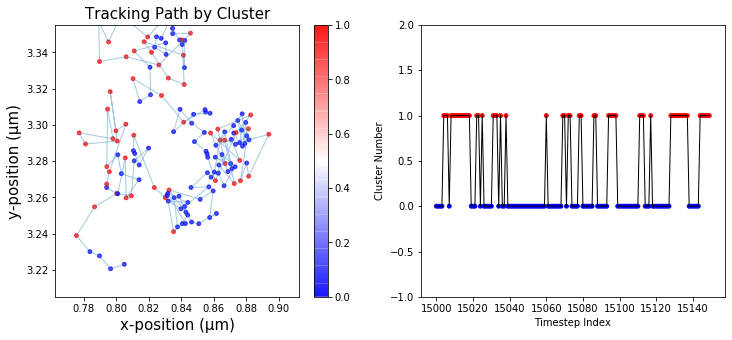

15500


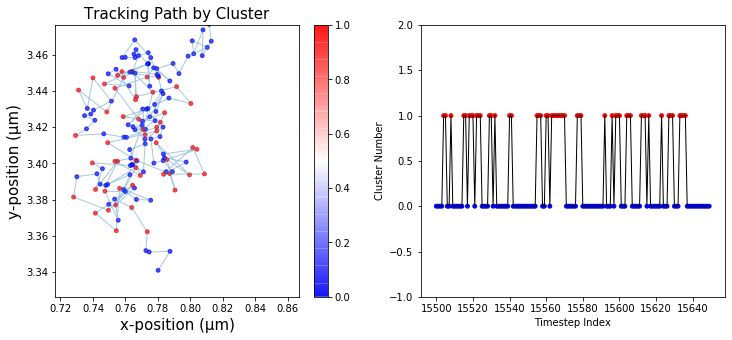

16000


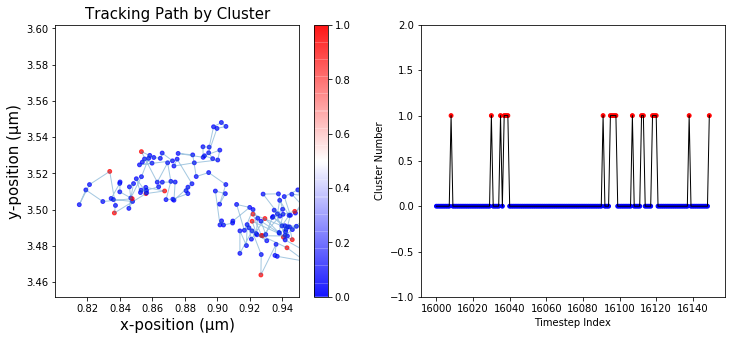

16500


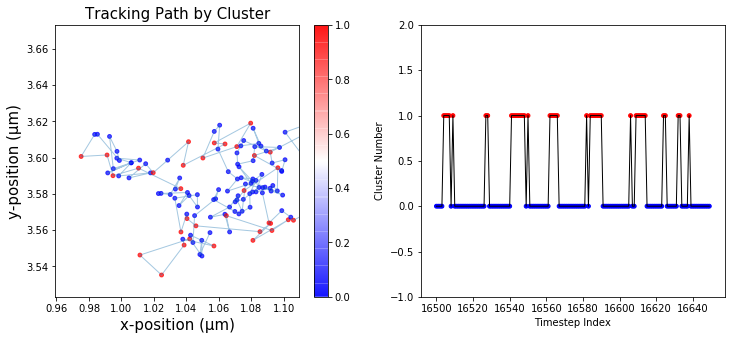

17000


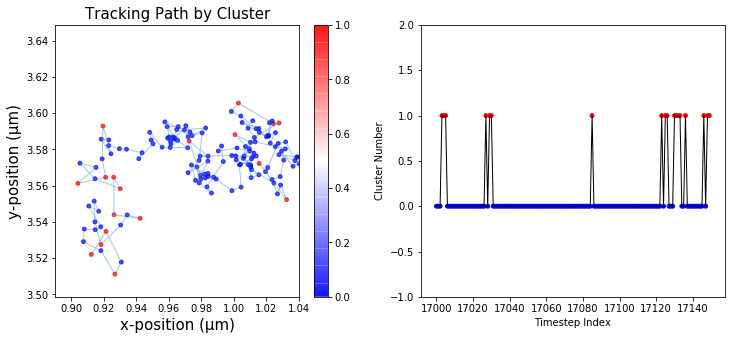

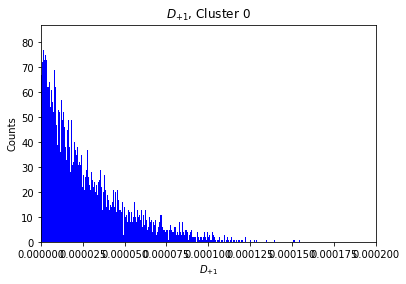

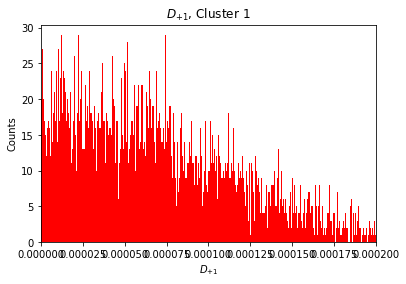

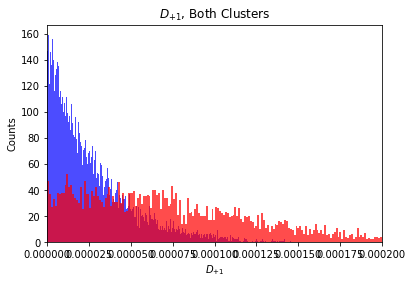

In [58]:
clusterer(LD_7, parameters)